References:

- There is an extensive [tutorial](https://scrnaseq-course.cog.sanger.ac.uk/website/index.html) from a course taught at the University of Cambridge.
- This notebook is mostly derived directly from the [Seurat tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html)

## Load libraries we will use

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject



## Download and prepare data

Here we assume that you have completed the 10X CellRanger pipeline to generate the count of matrices.

```bash
DIR=data
FILENAME=pbmc3k_filtered_gene_bc_matrices.tar.gz
if [ ! -f $DIR/$FILENAME ]; then
    mkdir $DIR
    wget https://bit.ly/3xbiCSz -O $DIR/$FILENAME
    cd $DIR
    tar -xzf $FILENAME
fi
```

Inspect the data files downloaded. The files of interest are in `data/filtered_gene_bc_matrices/hg19` and consist of

- `barcodes.tsv` A list of the 2,700 barcodes used, where each barcode represents a cell
- `genes.tsv` A mapping of gene IDs to gene symbols    
- `matrix.mtx` A matrix containing the UMI count per cell and gene combination

In [2]:
print(system("ls -R data", intern = TRUE))

 [1] "atlas_mouse.h5ad"                       
 [2] "filtered_gene_bc_matrices"              
 [3] "pbmc3k_filtered_gene_bc_matrices.tar.gz"
 [4] ""                                       
 [5] "data/filtered_gene_bc_matrices:"        
 [6] "hg19"                                   
 [7] ""                                       
 [8] "data/filtered_gene_bc_matrices/hg19:"   
 [9] "barcodes.tsv"                           
[10] "genes.tsv"                              
[11] "matrix.mtx"                             


In [3]:
print(system("head -3 data/filtered_gene_bc_matrices/hg19/barcodes.tsv", 
       intern = TRUE))

[1] "AAACATACAACCAC-1" "AAACATTGAGCTAC-1" "AAACATTGATCAGC-1"


In [4]:
print(system("head -3 data/filtered_gene_bc_matrices/hg19/genes.tsv", 
       intern = TRUE))

[1] "ENSG00000243485\tMIR1302-10" "ENSG00000237613\tFAM138A"   
[3] "ENSG00000186092\tOR4F5"     


The first line just reports the number of lines in `genes.tsv`, `barcodes.tsv` and `matrix.mtx` respectively. Subsequent lines are read as follows

- First column is gene_id given as line number in `genes.tsv`
- Second column is cell_id given as line number in `barcodes.tsv`
- Third column is UMI count for that cell/gene combination

Note that this particular organization is space-saving for sparse matrices. If we created a regular matrix of cells $\times$ genes, most entries would be filled by zeros.

In [5]:
print(system("head -5 data/filtered_gene_bc_matrices/hg19/matrix.mtx"
             , intern = TRUE))

[1] "%%MatrixMarket matrix coordinate real general"
[2] "%"                                            
[3] "32738 2700 2286884"                           
[4] "32709 1 4"                                    
[5] "32707 1 1"                                    


### Read data into a Seurat object

In [6]:
pbmc.data <- Read10X(data.dir = "data/filtered_gene_bc_matrices/hg19/")
pbmc <- CreateSeuratObject(
    counts = pbmc.data, 
    project = "pbmc3k", 
    min.cells = 3, 
    min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [7]:
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

   [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

### Preprocessing

#### Create QC metrics

#### Filter by mitochondrial gene proportion

Damaged or dead cells lose cytoplasmic RNA more easily than mitochondrial RNA, so a high proportion of mitochondrial genes is an indicator of a poor quality cell.

In [8]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [9]:
head(pbmc@meta.data, 5)

orig.ident nCount_RNA nFeature_RNA percent.mt
AAACATACAACCAC-1 pbmc3k     2419        779         3.0177759 
AAACATTGAGCTAC-1 pbmc3k     4903       1352         3.7935958 
AAACATTGATCAGC-1 pbmc3k     3147       1129         0.8897363 
AAACCGTGCTTCCG-1 pbmc3k     2639        960         1.7430845 
AAACCGTGTATGCG-1 pbmc3k      980        521         1.2244898

In [10]:
options(repr.plot.width = 8, repr.plot.height = 5)

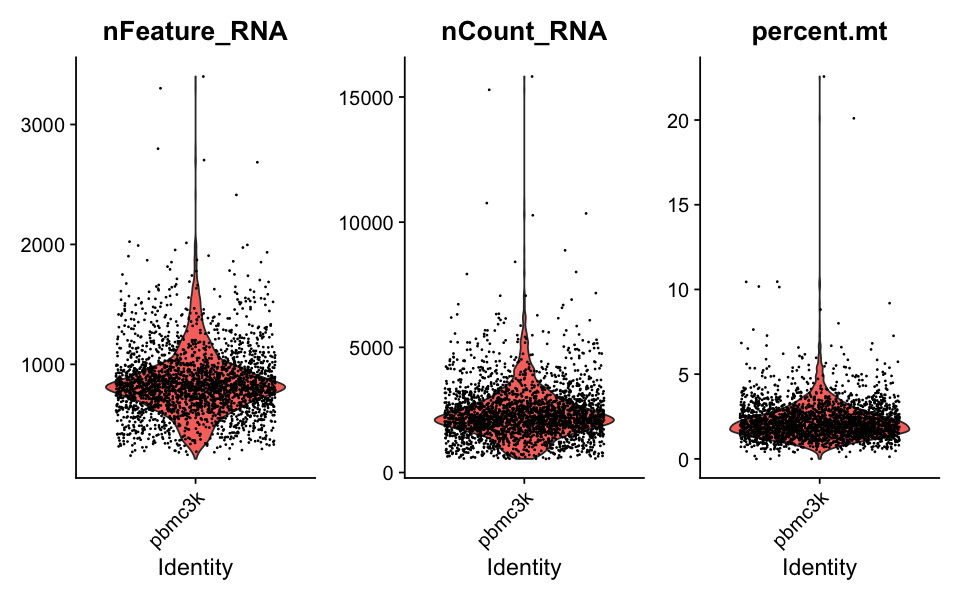

In [11]:
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

#### Filter by QC metrics

The most basic filters specify how many non-zero count genes you need to accept a cell, and how many cells have non-zero counts to accept a gene.

In [12]:
options(repr.plot.width = 8, repr.plot.height = 3)

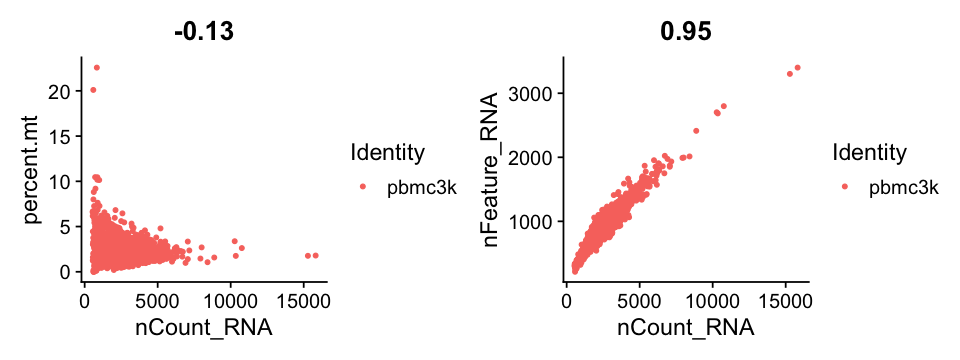

In [13]:
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [14]:
pbmc <- subset(
    pbmc, 
    subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5
)

### Normalize

Normalize to 10,000 reads per cell so that comparisons can be made.

In [15]:
pbmc <- NormalizeData(pbmc, 
                      normalization.method = "LogNormalize",
                      scale.factor = 10000)

### Find highly variable genes

In [16]:
pbmc <- FindVariableFeatures(
    pbmc, 
    selection.method = "vst", 
    nfeatures = 2000
)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

In [17]:
options(repr.plot.width = 12, repr.plot.height = 3)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


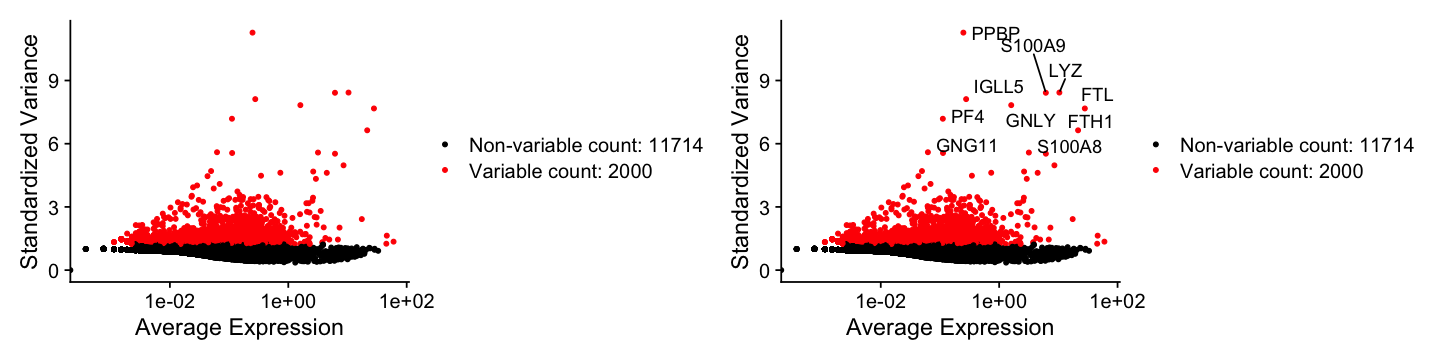

In [18]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

### PCA

Many genes in co-regulated pathways are likely to vary in the same way, and hence provide redundant information. PCA is a method to reduce linear redundancy and is often used as a first step in dimension reduction.

#### First scale the data

In [19]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



#### Now perform PCA

In [21]:
pbmc <- RunPCA(pbmc, 
               features = VariableFeatures(object = pbmc),
               verbose=FALSE)

In [22]:
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


#### Visualize data projected onto PC1 and PC2

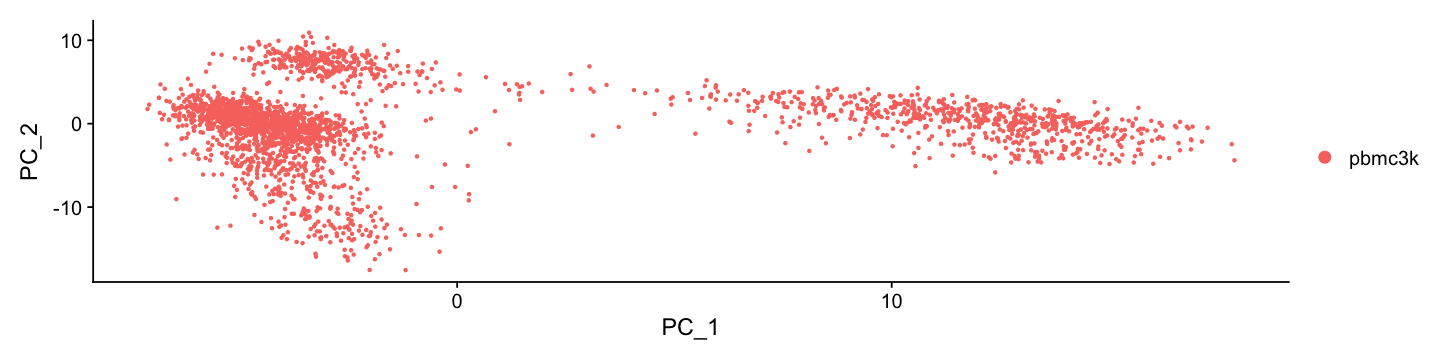

In [23]:
DimPlot(pbmc, reduction = "pca")

#### How much does each gene contribute to each PC?

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)

In [25]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

#### Estimate dimensionality of the data

In [26]:
ElbowPlot(pbmc)

### Compute neighborhood graph

This essentially creates a distance matrix between cells, using the PCA coordinates for each cell. Here we use values that Seurat uses.

In [27]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)

Computing nearest neighbor graph

Computing SNN



### Cluster the data using Louvain

In [28]:
pbmc <- FindClusters(pbmc, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


#### Clsuter using Leiden

```R
pbmc <- FindClusters(pbmc, resolution = 0.5, algorithm = 4)
```

### Uniform mapping approximation and projection (UNAP)

In [29]:
pbmc <- RunUMAP(pbmc, dims = 1:10, verbose=0)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [30]:
DimPlot(pbmc, reduction = "umap")

### t-stochastic neighbor embedding (t-sne)

In [31]:
pbmc <- RunTSNE(pbmc, dims = 1:10, verbose=0)

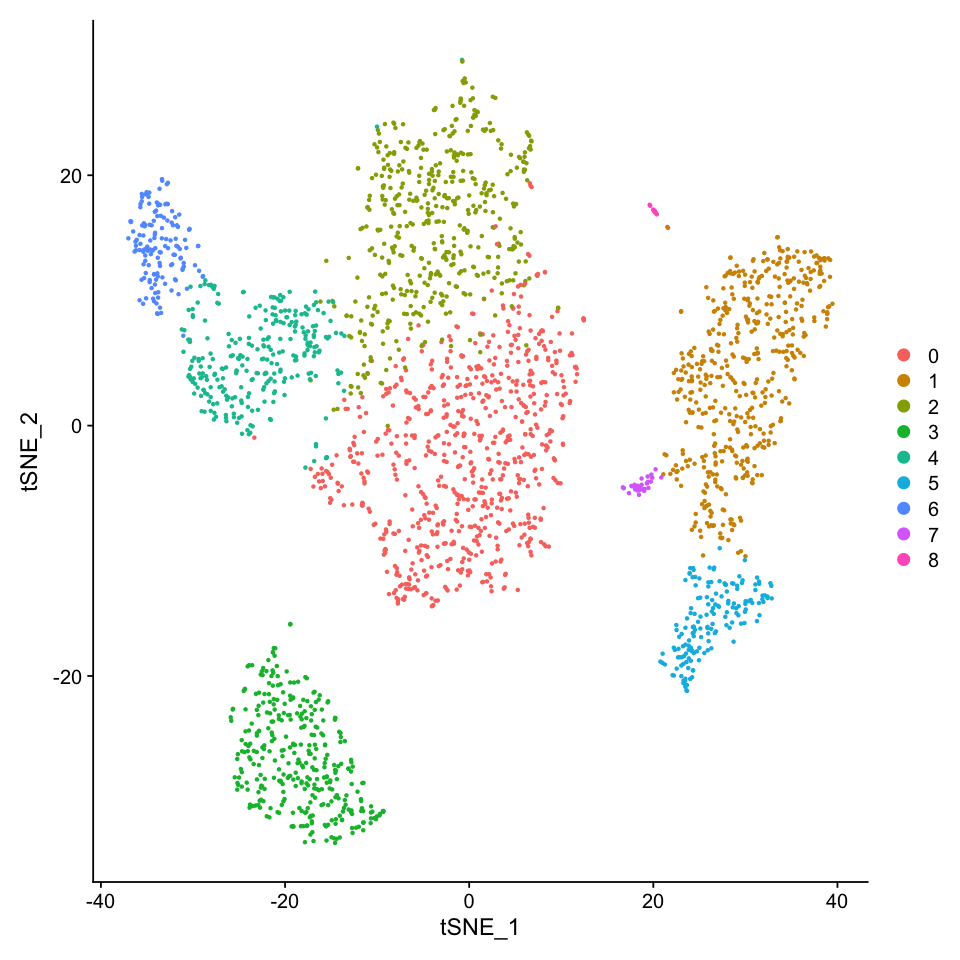

In [32]:
DimPlot(pbmc, reduction = "tsne")

### Finding signature genes

We can run simple statistical tests to identify genes that are differentially expressed across clusters, or "signature" genes. The default is the Wilcoxon Rank Sum Test.

In [33]:
install.packages('BiocManager')
BiocManager::install('limma')


The downloaded binary packages are in
	/var/folders/mv/nt1k4_751gjb0rjrkk41j7cm0000gn/T//Rtmp1PxVrW/downloaded_packages


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.5 (2021-03-31)

Installing package(s) 'limma'




The downloaded binary packages are in
	/var/folders/mv/nt1k4_751gjb0rjrkk41j7cm0000gn/T//Rtmp1PxVrW/downloaded_packages


Old packages: 'cluster', 'mgcv'



In [34]:
pbmc.markers <- FindAllMarkers(pbmc, 
                               only.pos = TRUE, 
                               min.pct = 0.25, 
                               logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [35]:
pbmc.markers %>% 
group_by(cluster) %>%
top_n(n = 2, wt = avg_log2FC)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1  1.740957e-109 1.069166   0.897 0.593 2.387549e-105 0       LDHB    
2   1.167632e-83 1.333503   0.435 0.108  1.601290e-79 0       CCR7    
3   0.000000e+00 5.570063   0.996 0.215  0.000000e+00 1       S100A9  
4   0.000000e+00 5.477394   0.975 0.121  0.000000e+00 1       S100A8  
5   7.994465e-87 1.282860   0.981 0.644  1.096361e-82 2       LTB     
6   2.610017e-59 1.240361   0.424 0.111  3.579377e-55 2       AQP3    
7   0.000000e+00 4.310172   0.936 0.041  0.000000e+00 3       CD79A   
8  9.481783e-271 3.591579   0.622 0.022 1.300332e-266 3       TCL1A   
9  1.167095e-178 2.966206   0.957 0.241 1.600553e-174 4       CCL5    
10 4.932509e-169 3.006739   0.595 0.056 6.764443e-165 4       GZMK    
11 3.511192e-184 3.311697   0.975 0.134 4.815249e-180 5       FCGR3A  
12 2.025672e-125 3.085654   1.000 0.315 2.778007e-121 5       LST1    
13 1.051911e-265 4.888172   0.986 0.071 1.442590e-261 6       GZMB    
14 6.823265e-175 4.917370   0.958 0.135 9.357425e-171 6       GNLY    
15 1.480764e-220 3.871151   0.812 0.011 2.030720e-216 7       FCER1A  
16  1.665286e-21 2.874465   1.000 0.513  2.283773e-17 7       HLA-DPB1
17 7.731180e-200 7.243377   1.000 0.010 1.060254e-195 8       PF4     
18 3.684548e-110 8.575862   1.000 0.024 5.052989e-106 8       PPBP

#### Compare expression of selected genes across all clusters

In [36]:
options(repr.plot.width = 8, repr.plot.height = 3)

In [37]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

Picking joint bandwidth of 0.0236

Picking joint bandwidth of 0.0228



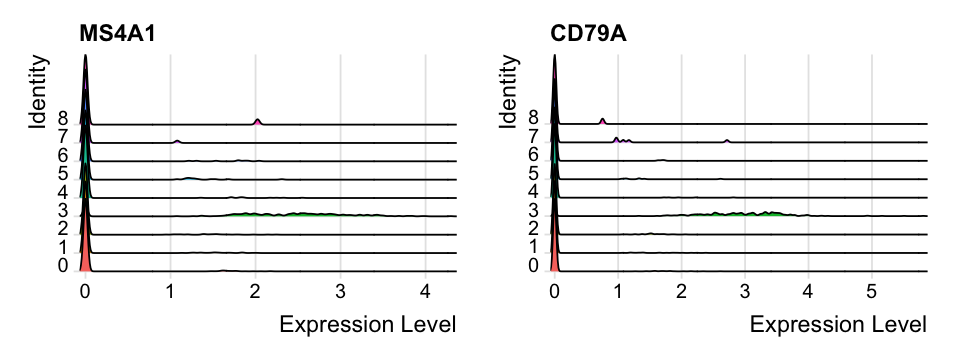

In [38]:
RidgePlot(pbmc, features = c("MS4A1", "CD79A"))

#### Plots colored by marker gene expression

In [39]:
options(repr.plot.width = 12, repr.plot.height = 12)

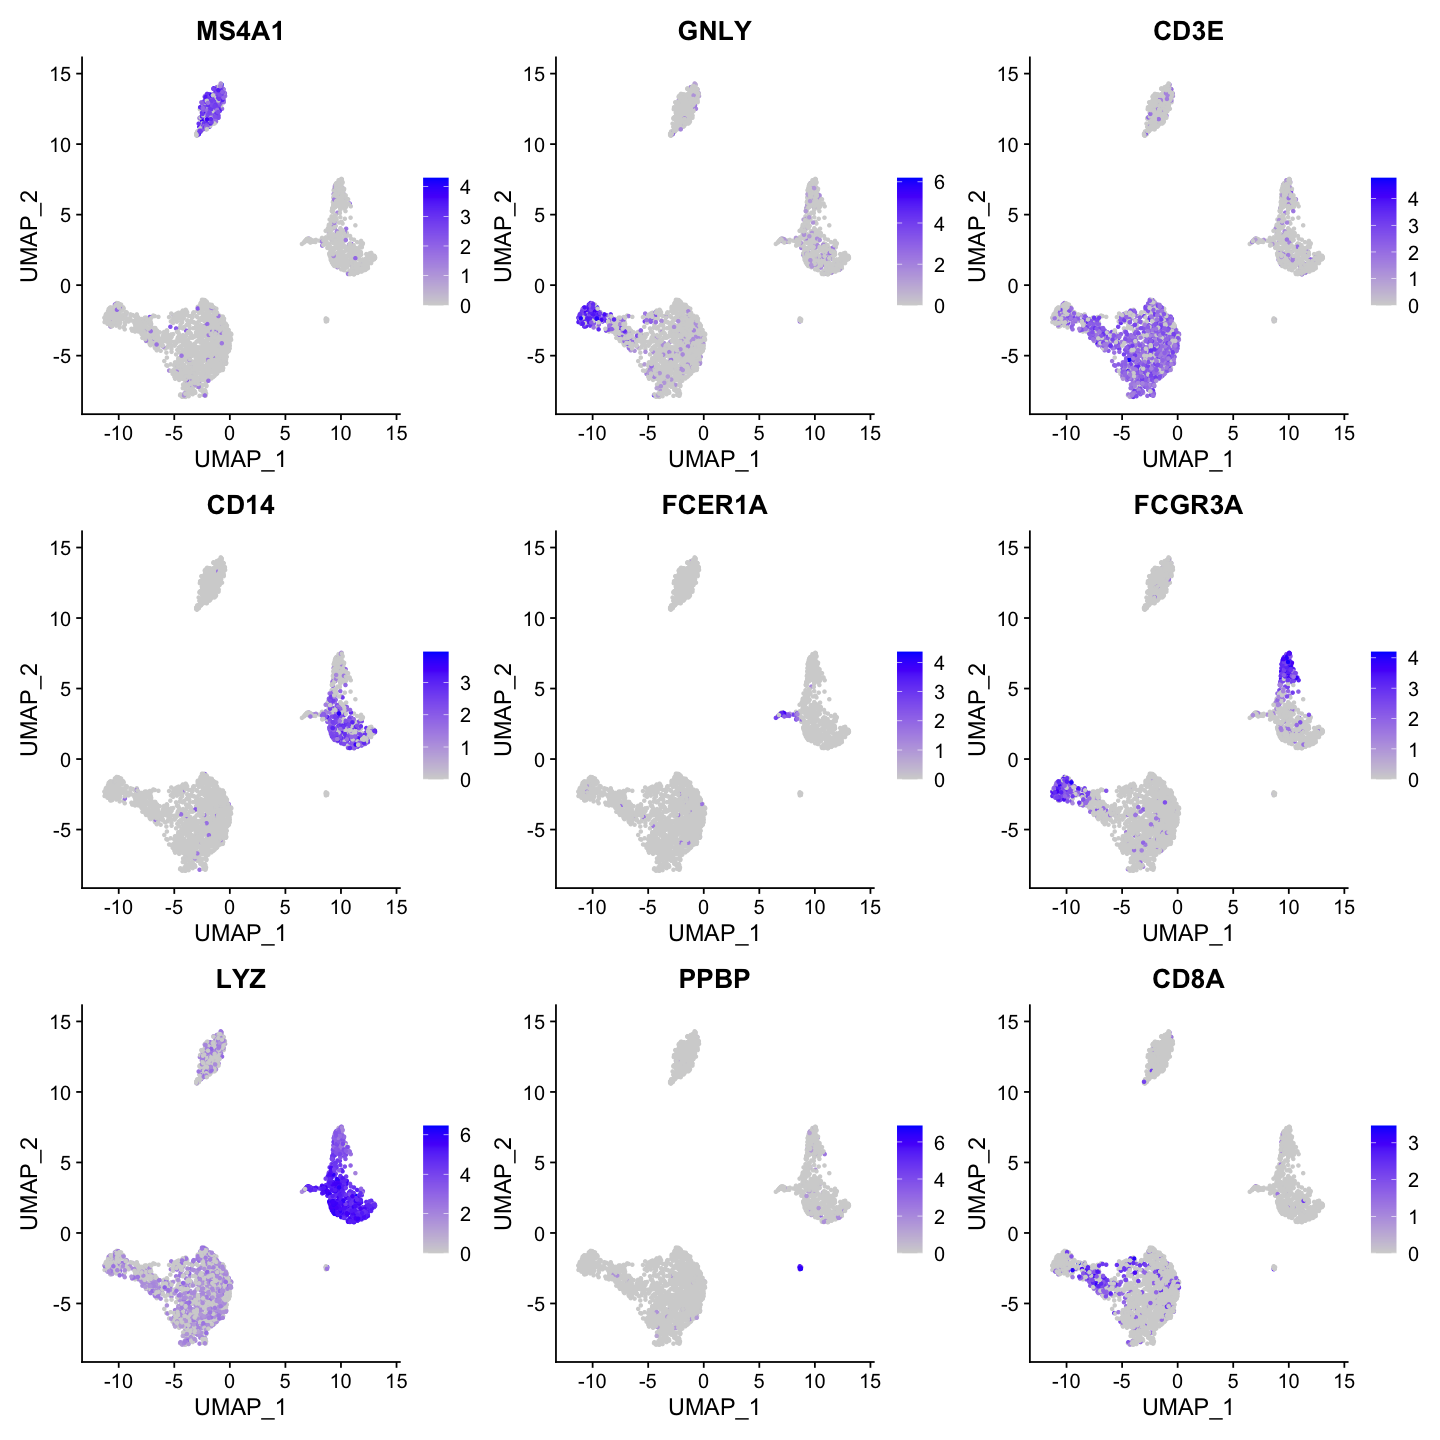

In [40]:
FeaturePlot(
    pbmc, 
    features = c("MS4A1", "GNLY", "CD3E", 
                 "CD14",  "FCER1A", "FCGR3A",
                 "LYZ", "PPBP", "CD8A"))

#### Plot a heatmap of top genes across cell types

In [41]:
top10 <- pbmc.markers %>% 
group_by(cluster) %>% 
top_n(n = 10, wt = avg_log2FC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

#### Manual labeling

If there are not too many cell clusters and you have the domain knowledge, you can name them manually.

In [42]:
options(repr.plot.width = 8, repr.plot.height = 8)

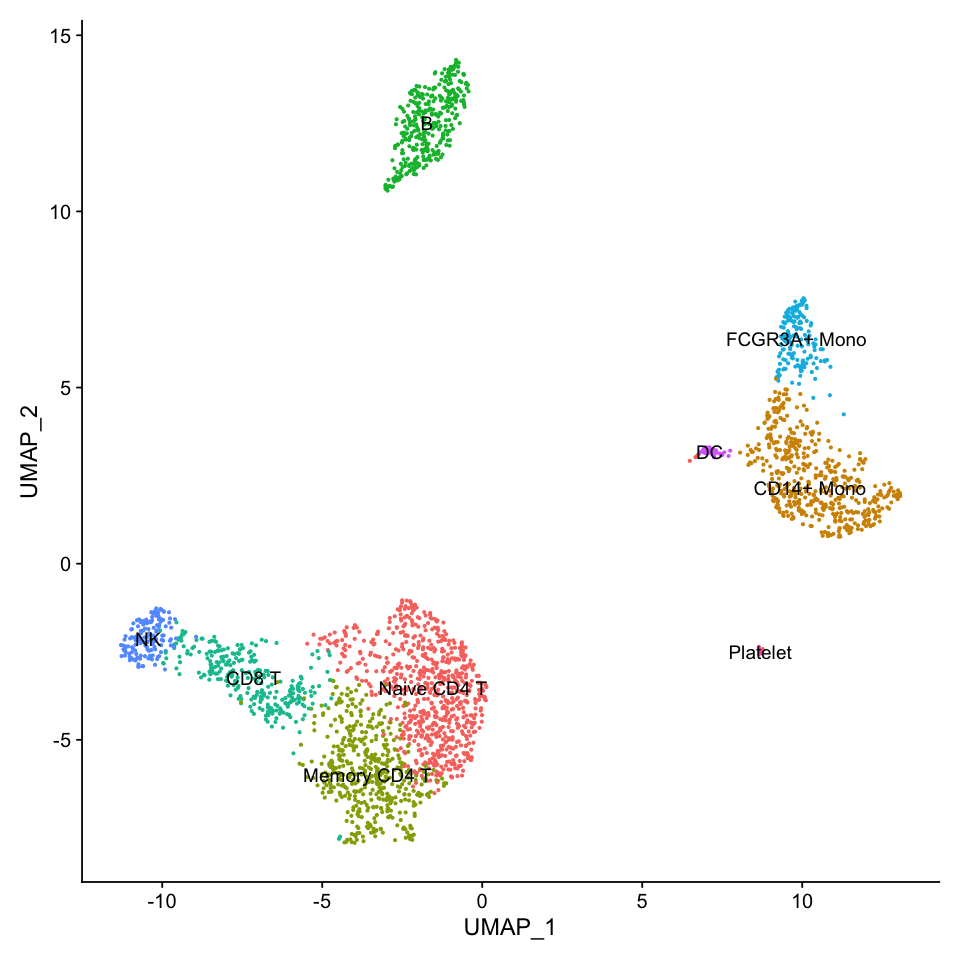

In [43]:
new.cluster.ids <- c(
    "Naive CD4 T", 
    "CD14+ Mono", 
    "Memory CD4 T",
    "B", 
    "CD8 T",
    "FCGR3A+ Mono", 
    "NK", 
    "DC",
    "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [44]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1    SeuratObject_4.0.0 Seurat_4.0.1       forcats_0.5.1     
 [5] stringr_1.4.0      dplyr_1.0.5        purrr_0.3.4        readr_1.4.0       
 [9] tidyr_1.1.3        tibble_3.1.1       ggplot2_3.3.3      tidyverse_1.3.1   

loaded via a namespace (and not attached):
  [1] Rtsne_0.15            colorspace_2.0-0      deldir_0.2-10        
  [4] ellipsis_0.3.1        ggridges_0.5.3        IRdisplay_1.0        
  [7] base64enc_0.1-3       fs_1.5.0              spatstat.data_2.1-0 